# Modeling the Delays

In this pyspark notebook, we will model the delay by fitting gamma distributions. To achieve that goal, the following steps will be performed :
1. Data Cleaning
2. Data Preprocessing
3. Data Modeling

## Creating spark application and libraries import

In [1]:
%%local
import os
import json
from IPython import get_ipython

username = os.environ['JUPYTERHUB_USER']
namespace = os.environ['CI_NAMESPACE']
project = os.environ['CI_PROJECT']

configuration = dict(
    name = f"{username}-namespace-project",
    executorMemory = "4G",
    executorCores = 4,
    numExecutors = 10,
    conf = {
        # "spark.pyspark.python": "/opt/anaconda3/bin/python3", # Use python3
        "spark.jars.repositories": "https://repos.spark-packages.org",
        "spark.jars.packages": "graphframes:graphframes:0.7.0-spark2.3-s_2.11"
    }
)


get_ipython().run_cell_magic('configure', line="-f", 
                             cell=json.dumps(configuration))

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6912,application_1618324153128_6539,pyspark,busy,Link,Link,None,
6914,application_1618324153128_6542,pyspark,busy,Link,Link,None,
6915,application_1618324153128_6543,pyspark,idle,Link,Link,None,
6916,application_1618324153128_6544,pyspark,idle,Link,Link,None,
6917,application_1618324153128_6545,pyspark,idle,Link,Link,None,
6918,application_1618324153128_6546,pyspark,idle,Link,Link,None,
6919,application_1618324153128_6547,pyspark,idle,Link,Link,None,
6921,application_1618324153128_6550,pyspark,idle,Link,Link,None,
6923,application_1618324153128_6552,pyspark,idle,Link,Link,None,
6924,application_1618324153128_6553,pyspark,busy,Link,Link,None,


In [2]:
# Launching Spark
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6927,application_1618324153128_6560,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.addPyFile('graphframes_graphframes-0.7.0-spark2.3-s_2.11.jar')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
import pandas
import datetime
import pyspark.sql.functions as F

from graphframes import *
from math import radians, cos, sin, asin, sqrt, floor
from pyspark.sql import Window
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, isnan, when, count

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 1 - Data Cleaning

Dropping lines null values or time inconsistencies.

In [11]:
# Loading the relevant data
df =  spark.read.orc("/data/sbb/orc/istdaten")
stop = spark.read.orc("/data/sbb/orc/geostops")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Take a sample for testing
# df = df.sample(0.01, 0)

# Keep only the needed information and rename
df = df.select(
          df['BETRIEBSTAG'].alias('date'), 
          df['PRODUKT_ID'].alias('transport_type'), 
          df['HALTESTELLEN_NAME'].alias('stop_name'), 
          F.to_timestamp(df["ABFAHRTSZEIT"], 'dd.MM.yyy HH:mm').alias("departure_time"),
          F.to_timestamp(df["AB_PROGNOSE"], 'dd.MM.yyyy HH:mm:ss').alias("actual_departure_time"),
          F.to_timestamp(df["ANKUNFTSZEIT"], 'dd.MM.yyy HH:mm').alias("arrival_time"),
          F.to_timestamp(df["AN_PROGNOSE"], 'dd.MM.yyyy HH:mm:ss').alias("actual_arrival_time"),
          df['AB_PROGNOSE_STATUS'].alias('status_departure_time'),
          df['AN_PROGNOSE_STATUS'].alias('status_arrival_time'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Exploring the data before cleaning
print("Initial number of lines : ", df.count())
print(df.where(df.arrival_time<df.departure_time).count())
print(df.where(df.actual_arrival_time<df.actual_departure_time).count())
print(df.where(df.actual_arrival_time == df.actual_departure_time).count())
print(df.filter((df.status_arrival_time.isin(['REAL','GESCHAETZT'])) | (df.status_departure_time.isin(['REAL','GESCHAETZT']))).count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

('Initial number of lines : ', 1415309386)
183925211
866474329
345397634
500026181

In [14]:
# Drop rows that are inconsistent for theoretical times
df = df.where(df.arrival_time >= df.departure_time)

# Dropping rows that are inconsistent for actual times - # NB : put back if enough data
# df = df.where(df.actual_arrival_time > df.actual_departure_time)

# Regarding the actual times, instead of filtering based on value we filter them by keeping only the ones that are tagged as REAL of GESCHAETZT (estimated) 
df = df.filter((df.status_arrival_time.isin(['REAL','GESCHAETZT'])) | (df.status_departure_time.isin(['REAL','GESCHAETZT'])))

# Drop rows that have null arrival_time or departure_time
for c in ['arrival_time', 'departure_time', 'actual_arrival_time', 'actual_departure_time']:
    df = df.where(F.unix_timestamp(col(c)).isNotNull())
    
# Check the current number of lines
print("Number of lines after cleaning : ", df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

('Number of lines after cleaning : ', 380661165)

### 2 - Data Preprocessing

Filtering on business day, no normal hours (8-20), in a 15 km radius from Zürich HBB.

It could have been an option not to filter out on the localisation to have more data, but as we are fitting 2 Gamma distributions per transport mode and per day, we do have more than enough data to fit such distributions. Moreover, focusing on journeys of the same area will increase the accuracy of such a modeling.

In [15]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

lat_zurich = 47.378177
lon_zurich = 8.540192

@F.udf
def in_zurich(lat, lon):
    return haversine_distance(lon, lat, lon_zurich, lat_zurich) < 15

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Udf to filter on the time of the day
@F.udf('string')
def timestamp_to_hms(timestamp):
    return str(timestamp)[-8:]

# Filter on the hour of the day
df = df.where((timestamp_to_hms(df.arrival_time) < "20:00:00") & (timestamp_to_hms(df.departure_time) > "07:00:00"))

# Filter on the week days (Monday to Friday)
df = df.withColumn('day_of_week', F.dayofweek(df.departure_time))
df = df.where(((df.day_of_week) >= 2) & ((df.day_of_week) <= 6))

# Filter in the range of 15km around Zurich HBB
stops_in_zurich = stop.filter(in_zurich(stop.stop_lat, stop.stop_lon) == True)
stops_in_zurich = list(stops_in_zurich.select('stop_name').toPandas()['stop_name'])
df = df.where(df.stop_name.isin(stops_in_zurich))

# Check the current number of lines
print("Number of lines after filtering : ", df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

('Number of lines after filtering : ', 5851719)

In [17]:
# Compute the departure and arrival delays
df = df.withColumn('departure_delay', (F.unix_timestamp(df['actual_departure_time'], 'dd.MM.yyy HH:mm:ss') - F.unix_timestamp(df['departure_time'], 'dd.MM.yyy HH:mm')))
df = df.withColumn('arrival_delay', (F.unix_timestamp(df['actual_arrival_time'], 'dd.MM.yyy HH:mm:ss') - F.unix_timestamp(df['arrival_time'], 'dd.MM.yyy HH:mm')))

# Check if there are any non defined values
delays = ['arrival_delay', 'departure_delay']
df.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull() | isnan(c), c)).alias(c) for c in delays]).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+---------------+
|arrival_delay|departure_delay|
+-------------+---------------+
|            0|              0|
+-------------+---------------+

In [18]:
# Check if there are any outliers - a delay will be considered as an outlier if this latter exceed 15 minutes
df.where((df['arrival_delay'] < -900)|(df['arrival_delay'] > 900)|(df['departure_delay'] < -900)|(df['departure_delay'] > 900)).head()

# Filter the outliers
df = df.where((df['arrival_delay'] > -900) & (df['arrival_delay'] < 900) & (df['departure_delay'] > -900) & (df['departure_delay'] < 900))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3 - Delay modeling

In order to model the delay, a good strategy would have been to group the edges by mean of transport and day of the week, after which each group would have been subject to a clusterization algorithm. Such a process would have unveiled the dependencies between different edges.

However, as the edges in the *istdaten* dataset describes less than 10% of the edges in the *stop_time* dataset, this strategy isn't valid.

Hence, another strategy has been formulated to this end : we will group the edges by mean of transport, day of the week, and finally time of the day. Notably, we will separate into two groups with respect to the time : during peak-time, and during off-peak time. We will consider peak-time hours as 7:00 AM to 8:00 AM, and 5:00 PM to 6:00 PM.

Finally, to make our different plots, we will send our delay data to the HDFS to benefit from the local python kernel.

In [24]:
# Transform the relevant information into a panda dataframe stored locally to plot
relevant_columns = ['transport_type', 'day_of_week', 'departure_time', 'arrival_time', 'departure_delay', 'arrival_delay']
pd_df = df.select(relevant_columns)

# Export to HDFS
pd_df.write.parquet('/user/kkobayas/final_project/gamma_distributions_entire_dataset.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      transport_type  day_of_week  ... departure_delay arrival_delay
0                Bus            5  ...             113           113
1                Bus            5  ...               4             4
2                Bus            5  ...             302           262
3                Bus            5  ...             295           295
4                Bus            5  ...              34            34
...              ...          ...  ...             ...           ...
38120            Bus            3  ...             355           335
38121            Bus            3  ...             352           352
38122            Bus            3  ...             370           352
38123            Bus            3  ...             375           375
38124            Bus            3  ...             354           323

[5844224 rows x 6 columns]


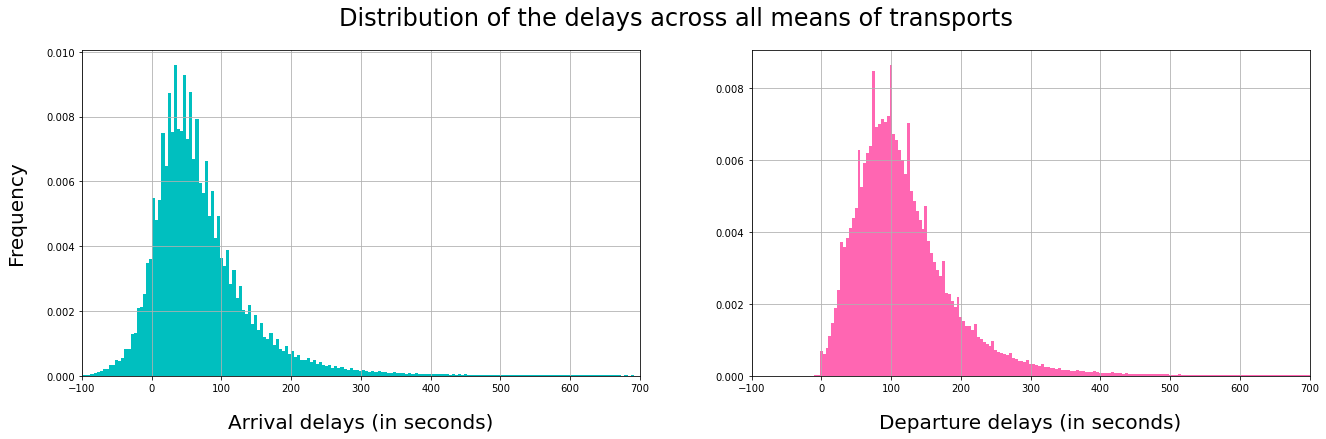

In [49]:
%%local
import matplotlib
import matplotlib.pylab as plt
import datetime
import pandas as pd
import numpy as np
import pickle as pkl
from scipy.stats import gamma
from hdfs3 import HDFileSystem

# Function to load our delay dataframe from HDFS to a pandas dataframe
def load_hdfs_to_pandas(filename):
    hdfs = HDFileSystem(host='hdfs://iccluster040.iccluster.epfl.ch', port=8020, user='ebouille') # impersonate ebouille to read the file
    files = hdfs.glob(f'/user/kkobayas/final_project/{filename}')
    df = pd.DataFrame()
    for file in files:
        if not 'SUCCESS' in file:
            with hdfs.open(file) as f:
                df = df.append(pd.read_parquet(f))    
    return df

# Load the dataframe
pd_df = load_hdfs_to_pandas('gamma_distributions_entire_dataset.parquet')
print(pd_df)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
axes[0].hist(pd_df.arrival_delay, color='c', bins=400, density = True, stacked = True)
axes[1].hist(pd_df.departure_delay, color='#ff66b2', bins=400, density = True, stacked = True)

# Legends
fig.suptitle('Distribution of the delays across all means of transports', fontsize=24)
axes[0].set_xlabel('Arrival delays (in seconds)', fontsize=20, labelpad=20)
axes[0].set_ylabel('Frequency', fontsize=20, labelpad=20)
axes[0].set_xlim(-100, 700)
axes[0].grid(True)
axes[1].set_xlabel('Departure delays (in seconds)', fontsize=20, labelpad=20)
axes[1].grid(True)
axes[1].set_xlim(-100, 700)

# Show the plot locally
plt.show()

      transport_type  day_of_week  ... departure_delay arrival_delay
0                Bus            5  ...             113           113
1                Bus            5  ...               4             4
2                Bus            5  ...             302           262
3                Bus            5  ...             295           295
4                Bus            5  ...              34            34
...              ...          ...  ...             ...           ...
38120            Bus            3  ...             355           335
38121            Bus            3  ...             352           352
38122            Bus            3  ...             370           352
38123            Bus            3  ...             375           375
38124            Bus            3  ...             354           323

[5844224 rows x 6 columns]


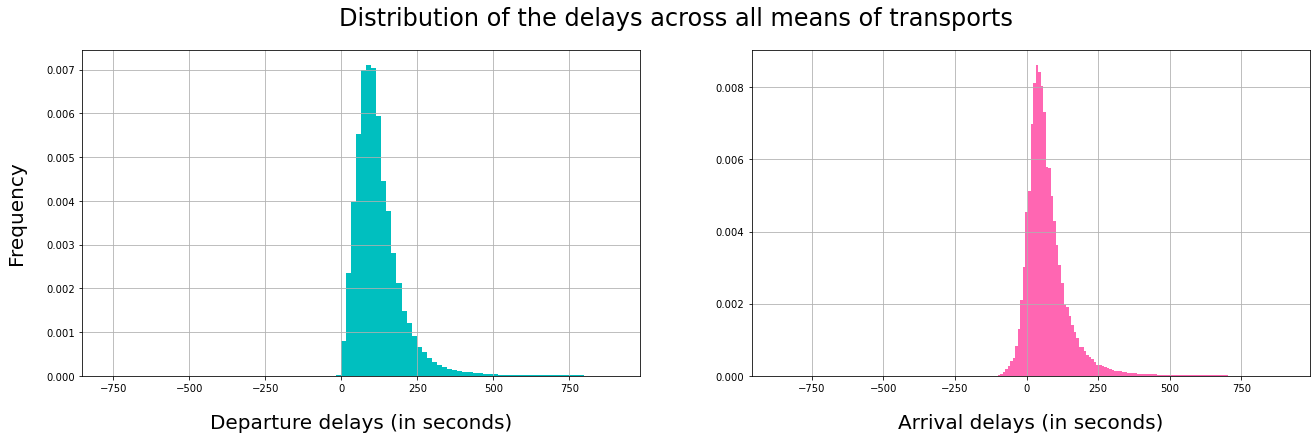

In [45]:
%%local
import matplotlib
import matplotlib.pylab as plt
import datetime
import pandas as pd
import numpy as np
import pickle as pkl
from scipy.stats import gamma
from hdfs3 import HDFileSystem

# Function to load our delay dataframe from HDFS to a pandas dataframe
def load_hdfs_to_pandas(filename):
    hdfs = HDFileSystem(host='hdfs://iccluster040.iccluster.epfl.ch', port=8020, user='ebouille') # impersonate ebouille to read the file
    files = hdfs.glob(f'/user/kkobayas/final_project/{filename}')
    df = pd.DataFrame()
    for file in files:
        if not 'SUCCESS' in file:
            with hdfs.open(file) as f:
                df = df.append(pd.read_parquet(f))    
    return df

# Load the dataframe
pd_df = load_hdfs_to_pandas('gamma_distributions_entire_dataset.parquet')
print(pd_df)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
axes[0].hist(pd_df.departure_delay, color='c', bins=400, density = True, stacked = True)
axes[1].hist(pd_df.arrival_delay, color='#ff66b2', bins=400, density = True, stacked = True)

# Legends
fig.suptitle('Distribution of the delays across all means of transports', fontsize=24)
axes[0].set_xlabel('Departure delays (in seconds)', fontsize=20, labelpad=20)
axes[0].set_ylabel('Frequency', fontsize=20, labelpad=20)
axes[0].set_xlim(-100, 700)
axes[0].grid(True)
axes[1].set_xlabel('Arrival delays (in seconds)', fontsize=20, labelpad=20)
axes[0].set_xlim(-100, 700)
axes[1].grid(True)

# Show the plot locally
plt.show()

The plots are looking good - let us make the same plots, by grouping as described at the beginning of the section, and fit a **gamma distribution** on each of them.

However, we will only model the delays of the arrivals as it is not relevant to do so for the departures - indeed, **the departures' delays are never negative**, so it will not have any impact in the decision process when computing confidence scores for a path. What is important in the decision making is whether a given traveler will be able to **arrive at the station before the scheduled time of a departure of a trip**.

In [21]:
%%local

# Casting the timestamps into datetime
pd_df['arrival_time'] = pd.to_datetime(pd_df['arrival_time'].astype(str).str.split('+').map(lambda x:x[0]))
pd_df['departure_time'] = pd.to_datetime(pd_df['departure_time'].astype(str).str.split('+').map(lambda x:x[0]))

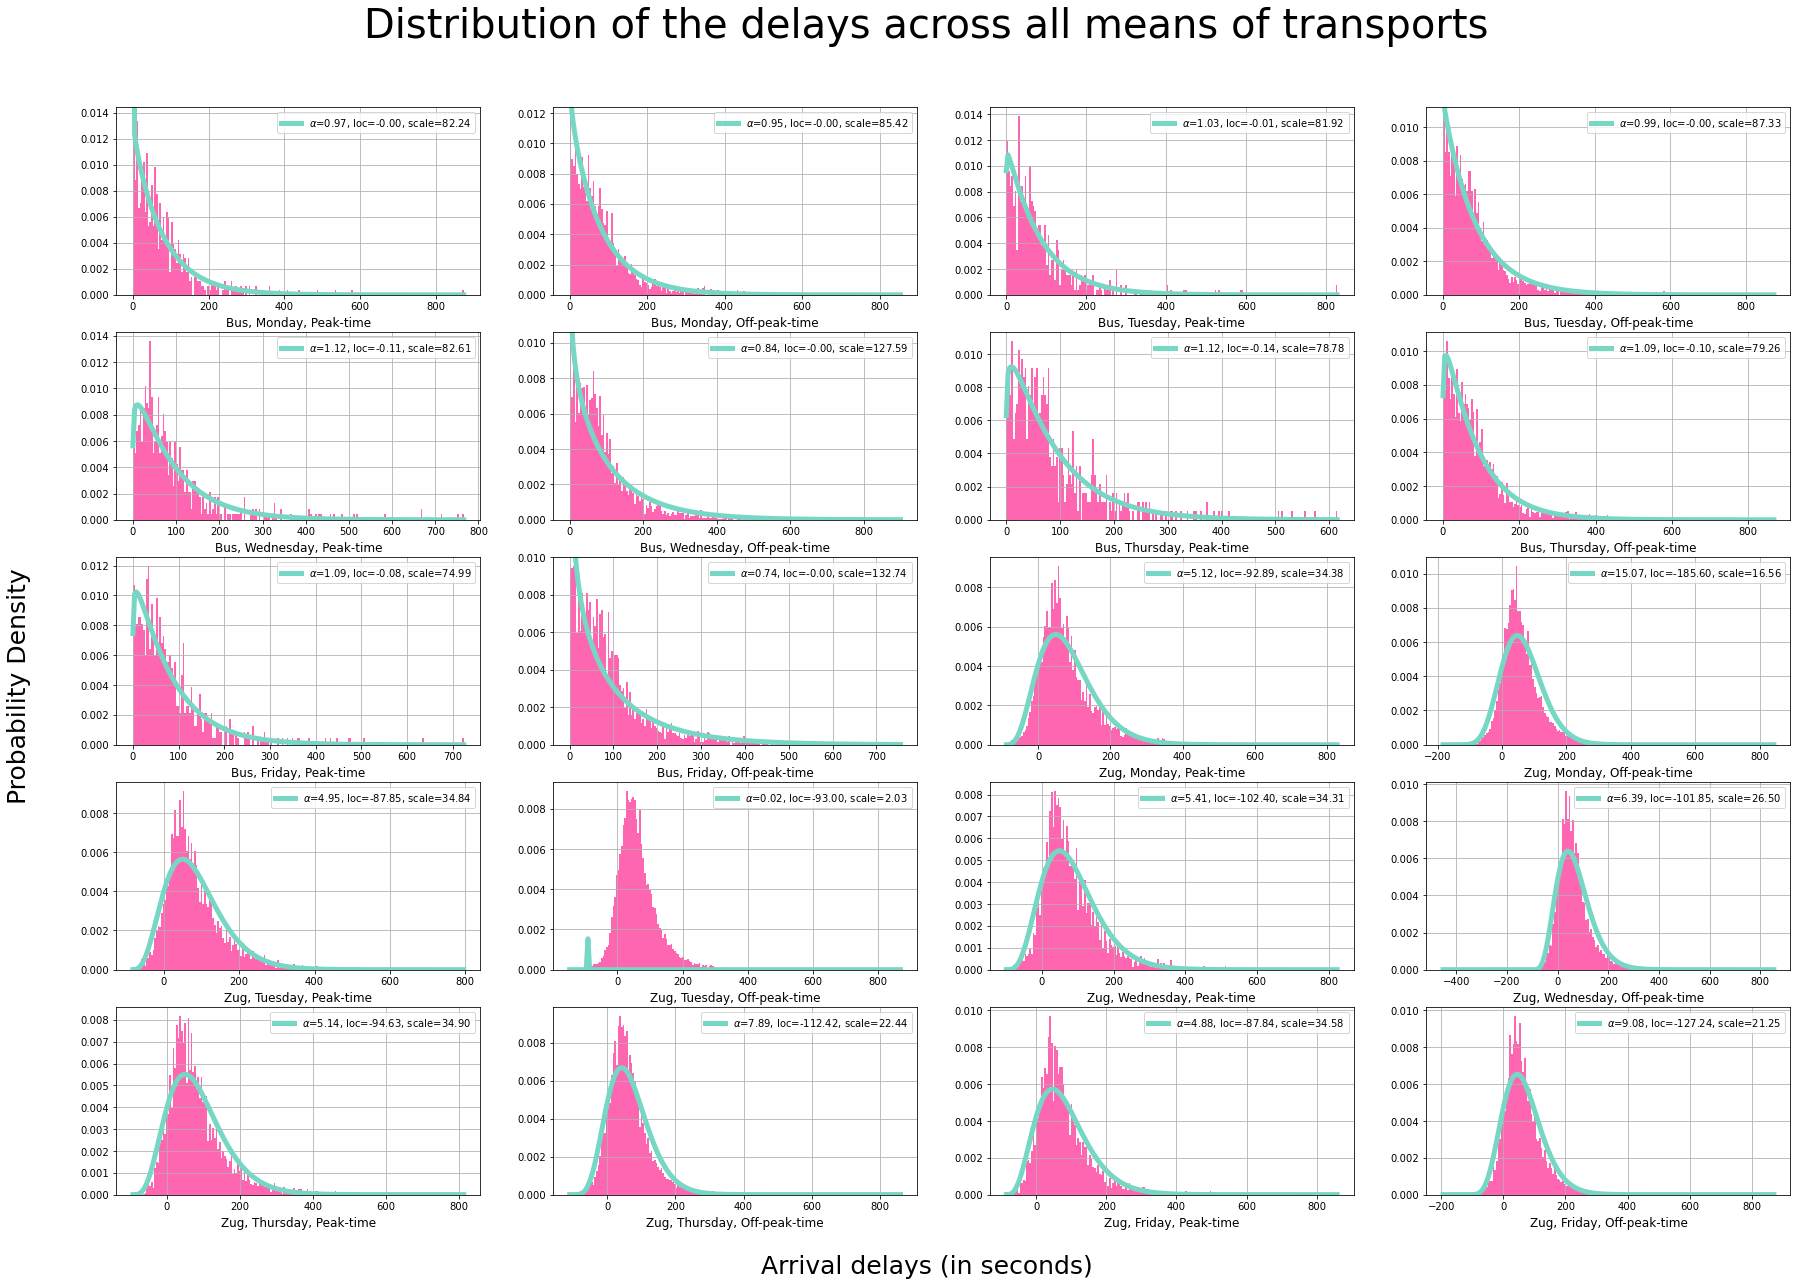

In [44]:
%%local

# Groups - 20 cases
means_transport = ['Bus','Zug']
days_of_week = range(2, 7)
map_int_day_to_str = {2:"Monday", 3:"Tuesday", 4:"Wednesday", 5:"Thursday", 6:"Friday"}
peak_times_bounds = [[datetime.time(7,0,0), datetime.time(8,0,0)], [datetime.time(17,0,0), datetime.time(18,0,0)]]

# Initialize the figure
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(30,20))

# Compute the peak time indexes
arrival_time = pd_df.arrival_time.dt.time
departure_time = pd_df.departure_time.dt.time
peak_time_idx = []
for peak_time in peak_times_bounds :
    peak_time_idx.append(((arrival_time<peak_time[1]) & (arrival_time>peak_time[0])) | ((departure_time<peak_time[1]) & (departure_time>peak_time[0])))
peak_time_idx = peak_time_idx[0] | peak_time_idx[1]

# Gamma parameters accumulator
gamma_params_dict = {}

# Plot each of the groups
axe_x = 0
axe_y = 0
for mt in means_transport :
    for dow in days_of_week :
        for pt in [True, False] :
            
            # Get the indexes with respect to whether we are considering the peak time or not
            pt_idx = peak_time_idx if pt else -peak_time_idx
            pt_str = "Peak-time" if pt else "Off-peak-time"
            
            # Name of the group
            name = mt + ', ' + map_int_day_to_str[dow] + ', ' + pt_str
            
            # Filter the relevant delays
            arrival_delays = pd_df[(pd_df.transport_type==mt) & (pd_df.day_of_week == dow) & (pt_idx)].arrival_delay
            
            # Fit a gamma distribution
            fit_alpha, fit_loc, fit_scale = gamma.fit(arrival_delays, loc = arrival_delays.min())
            gamma_params_dict[name] = {'fit_alpha':fit_alpha, 'fit_loc':fit_loc, 'fit_scale':fit_scale}
            
            # Plot histogram
            axes[axe_y][axe_x].hist(arrival_delays, color='#ff66b2', bins=200, density = True, stacked = True)
            ylimits = axes[axe_y][axe_x].get_ylim() 
            
            # Plot the gamma distribution
            x = np.linspace(arrival_delays.min(), arrival_delays.max(), 200)            
            axes[axe_y][axe_x].plot(x, gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_scale),
                                    label = rf'$\alpha$={fit_alpha:.2f}, loc={fit_loc:.2f}, scale={fit_scale:.2f}', 
                                    color='#76d7c4', linewidth=5)
            
            # Display the legend
            axes[axe_y][axe_x].legend()
            
            # Reset the y limits
            axes[axe_y][axe_x].set_ylim(ylimits)
            
            # Set grid
            axes[axe_y][axe_x].grid(True)
            
            # Change tick size
            axes[axe_y][axe_x].tick_params(axis='both', which='major', labelsize=10)
            
            # Add group information
            axes[axe_y][axe_x].set_xlabel(name, fontsize=12, labelpad=5)

            # Increment the plot index
            axe_x += 1
            if (axe_x % 4==0):
                axe_x = 0
                axe_y += 1
                
# Legends
fig.suptitle('Distribution of the delays across all means of transports', fontsize=40, y=0.95)
fig.text(0.5, 0.07, 'Arrival delays (in seconds)', ha='center', fontsize=25)
fig.text(0.08, 0.4, 'Probability Density', ha='center', fontsize=25, rotation='vertical')

# Show the plot locally
plt.show()

We can see that the each of the gamma distributions fit the delays of a given group pretty well !

In [39]:
%%local

# Print the results
print(gamma_params_dict)

# Save the results
pickle_file = open("../data/gamma_distributions.pkl", "wb")
pkl.dump(gamma_params_dict, pickle_file)
pickle_file.close()

{'Bus, Monday, Peak-time': {'fit_alpha': 0.9709048768932098, 'fit_loc': -5.505192650902178e-20, 'fit_scale': 82.24437136433173}, 'Bus, Monday, Off-peak-time': {'fit_alpha': 0.9517171472001775, 'fit_loc': -1.2974795008342837e-21, 'fit_scale': 85.42037963199087}, 'Bus, Tuesday, Peak-time': {'fit_alpha': 1.0274513624734998, 'fit_loc': -0.008135542077325454, 'fit_scale': 81.92457345588427}, 'Bus, Tuesday, Off-peak-time': {'fit_alpha': 0.9944002162463415, 'fit_loc': -1.8557072072202688e-18, 'fit_scale': 87.33306096540016}, 'Bus, Wednesday, Peak-time': {'fit_alpha': 1.1239591655473342, 'fit_loc': -0.10721905557736003, 'fit_scale': 82.61003459512767}, 'Bus, Wednesday, Off-peak-time': {'fit_alpha': 0.8410633651063977, 'fit_loc': -4.0189550482493757e-19, 'fit_scale': 127.58855392517776}, 'Bus, Thursday, Peak-time': {'fit_alpha': 1.1204806132730996, 'fit_loc': -0.14410499121336381, 'fit_scale': 78.783050516417}, 'Bus, Thursday, Off-peak-time': {'fit_alpha': 1.0873388013422702, 'fit_loc': -0.0993